<a href="https://colab.research.google.com/github/abougabal/DATABASE_WEB/blob/master/Location_tracking_Data_Augmentation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 1. Objective
*   Learn to understand scientific papers. 
*   Learn how to mitigate the noise in wireless channels and increase the density of the fingerprint using data augmentation techniques.
*   Learn how to implement and evaluate the data augmentation techniques.

# 2. Problem statement
The problem we are trying to solve here is finding user estimated location from a scan of the received signal strength (RSS) coming from the different APs in the environment using Deep learning-based fingerprinting techniques. As the size of training data is small, we need to apply the different data augmentation techniques to increase the density of training data (i.e. the fingerprint).
>## Offline phase
> The input to the problem is the fingerprint (which is collected in an offline calibration phase). The fingerprint is the RSS from the different APs in the environment geo-tagged with the location. The following code defines a fingerprint with 24 RSS samples with their fingerprinting locations *fingerprint_locs*. Each sample in the fingerprint consists of a scan of the RSS coming from the different APs (mainly four APs) and the groundtruth location (the true location). e.g the first sample has RSS scan from four APs: [-64., -73., -70., -85.] dBm and its true location is [11.74, 6.76] meter.


In [ ]:
'''
Fingerprint data
'''
fingerprint_rss = [[-64., -73., -70., -85.], \
                   [-57., -63., -81., -84.], \
                   [-54., -51., -75., -75.], \
                   [-45., -72., -90., -54.], \
                   [-69., -84., -100., -81.], \
                   [-55., -100., -66., -84.], \
                   [-54., -60., -69., -84.], \
                   [-39., -65., -78., -69.], \
                   [-84., -69., -69., -57.], \
                   [-65., -100., -100., -77.], \
                   [-69., -100., -87., -100.], \
                   [-63., -75., -90., -100.], \
                   [-84., -78., -84., -81.], \
                   [-70., -73., -85., -88.], \
                   [-61., -61., -91., -85.], \
                   [-79., -85., -67., -100.], \
                   [-87., -84., -78., -100.], \
                   [-78., -100., -66., -100.], \
                   [-87., -100., -39., -100.], \
                   [-67., -100., -100., -85.], \
                   [-70., -85., -100., -79.], \
                   [-69., -100., -100., -90.], \
                   [-100., -100., -82., -100.], \
                   [-83., -93., -77., -100.]]  # dBm

# location coordinates are in pixels to convert it to meters divide by 100 (first location is 11.74 in x direction and 6.76 in y direction) 

fingerprint_locs = [[1174, 676], \
                    [1586, 695], \
                    [2000, 670], \
                    [2376, 694], \
                    [2783, 998], \
                    [1256, 688], \
                    [1644, 674], \
                    [2043, 677], \
                    [2462, 678], \
                    [2860, 1083], \
                    [1149, 1406], \
                    [2157, 1103], \
                    [1744, 1128], \
                    [1206, 359], \
                    [1764, 350], \
                    [500, 252], \
                    [800, 247], \
                    [704, 659], \
                    [247, 650], \
                    [2197, 252], \
                    [2675, 347], \
                    [3146, 309], \
                    [826, 1169], \
                    [413, 1160]]

>The data augmentation techniques can be used to extend this small input dataset to a larger dataset suitable for training deep learning models. In particular, here, it is required to implement: the additive noise, random-based signal dropper, and threshold-based signal dropper techniques. For each scan in the input data, it is required to generate three new samples (+ the original scan) using each of the following augmentation technique.

>## Additive Noise
Typically, when both the transmitter and receiver are stationary, the RSS changes over time. This is due to the dynamic changes in the environment and the noisy wireless channel. The additive noise data augmentation technique builds on this observation. In particular, for each RSS scan, it adds a white Gaussian noise q with zero mean and a standard deviation s to each entry. Note s is parameter (make it = 1 in your results).



>## AP Dropper
When the device is stationary at a certain location, the number of APs it hears over different scans varies. This is due to the receiver’s sensitivity, where weak APs, whose signal changes over time, will be dropped randomly. The AP dropping techniques increase the training data
size by generating synthetic training samples that reflect this
behavior by dropping APs (setting their
values to -100) in the input scan. We introduce two novel
tower dropping techniques: The random-based dropper and the
threshold-based dropper.

>>A. Random-based dropper: The idea is to randomly drop (set
RSS to -100) signals from the detected AP (other
than the ones that is already = -100 to reflect the real case). This operation
masks out some RSS readings from the RSS vector, simulating
the case when the different neighboring cell towers appear and
disappear at the same location over time. You can drop up to one heard APs in a a scan. So each sample [-30, -40, -50, -100] will be splitted to zero drop: [-30, -40, -50, -100] and one random drop: [-100, -40, -50, -100].

>>B. Threshold-based dropper: This technique modifies an
input RSS vector such that any entry  whose value falls
below a predefined threshold is a candidate to be removed (set
to -100), mimicking that this AP has not been heard in
the generated synthetic sample. You can set the threshold value -85dBm.


>It is required to use the previous fingerprint without any augmentation, with each augmentation technique individually, and with all augmentation techniques together (threshold drop then random drop then additive noise) to train a simple Classifier neural network. The input to the network is the RSS coming from different cell towers in the environment (features) or in other works the RSS vector from the fingerprint. The output is the probability distribution for different fingerprint locations in the area of interest. The following figure explains the network structure. The input is the RSS vector from M access points (in our case M=4). The output is the probability of the different K locations in the fingerprint (in our case K=24). 

>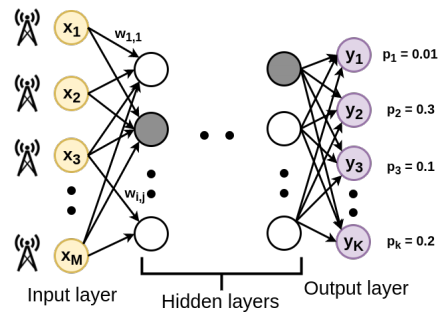

> In the offline phase, you are required to train the deep learning model using the fingerprinting samples. The data provided to the model is X,Y. The X is the RSS matrix for the (M access point * K samples). The Y is the one-hot encoding vectors for the ground truth locations. E.g. If you have K discrete locations in the fingerprint and the ground truth for a sample is the first location of the K, then the one-hot encoding vector corresponds to this sample is $[1,0,0,...,0]$. It means that the probability of the first location is 1, while the probability of the other K-1 locations is 0.   

> To train the deep model you need:

1.   Install the important frameworks.

In [ ]:
# Excute this cell only once.
# !pip install -qq tensorflow-gpu keras tqdm

2.   Import the Keras packages 

In [ ]:
import tensorflow as tf
import keras
from keras.models import Sequential
from keras.layers import Dense, Conv2D, Flatten, Conv1D, Dropout, Activation, MaxPooling2D
from keras.optimizers import Adam, SGD
import keras.backend as K
from pylab import *
import torch
from tensorflow.keras import regularizers
import numpy as np
import random

3.   Define your model 

In [ ]:
# Defines the model to be trained
# The model F256->ReLU->F128->ReLU->F64->ReLU->F Output->Softmax       F means full dense layer
# You might want to add some Dropout layers as follows model.add(Dropout(0.5))
def model_1():
  fc_model = tf.keras.Sequential()
  fc_model.add(Dense(256,activation="relu",input_shape=(4,)))
  fc_model.add(Dropout(0.5))
  fc_model.add(Dense(128,activation="relu"))
  #fc_model.add(Dropout(0.5))
  fc_model.add(Dense(64,activation="relu"))
  fc_model.add(Dense(24,activation="softmax"))
  return fc_model


In [ ]:
def one_hot_encoded_vec(r=24,c=24):
  rows, cols = (r, c)
  encoded=[]
  for i in range(rows):

    col = []
    for j in range(cols):
      col.append(0)
    encoded.append(col)
  for i in range (24):
    for j in range (24):
      if(i==j):
        encoded[i][i]=1
  return encoded

4.   Train your model 

In [ ]:
# Defines the parameters used and trains the model epochs = 10, batch size = 2, learning rate = 0.0001, loss is categorical_crossentropy, optimizer is Adam.
def train_model(fingerprint_rss_train,encoded):
  location_model_1=model_1()
  location_model_1.summary()
  location_model_1.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3), 
              loss='categorical_crossentropy',
              metrics=['accuracy'])
  BATCH_SIZE = 2
  EPOCHS = 10
  nn_hist = location_model_1.fit(fingerprint_rss_train ,encoded , batch_size=BATCH_SIZE, epochs=EPOCHS)
  return location_model_1


In [ ]:
def Test_model(test_rss,encoded_vec,batch_size=2):

  score, accuracy = location_model_1.evaluate(test_rss, encoded_vec, batch_size=2, verbose=0)
  print("Test X fraction correct (NN-Score) = {:.2f}".format(score))
  print("Test X fraction correct (NN-Accuracy) = {:.2f}".format(accuracy))

In [ ]:
def CDF_draw(loc_err_ec,label_2):
    hist_1,bin_edges_1=np.histogram(loc_err_ec)
    pdf = hist_1 / sum(hist_1)
    CFD1=np.cumsum(pdf)
    plt.plot(bin_edges_1[1:], CFD1, label=label_2)
    return None

In [ ]:
def one_hot_encoder_func(r,c,number_of_samples=3):

  encoded2=[]
  counter=0
  down_counter=number_of_samples+1
  for i in range(r):
    col = []
    for j in range(24):
      col.append(0)
    encoded2.append(col)
  for i in range(r):
    encoded2[i][counter]=1
    down_counter=down_counter-1
    if(down_counter==0):
      counter=counter+1
      down_counter=number_of_samples+1
  return encoded2    



In [ ]:
def Additive_noise(s=1):
  fingerprint_rss_noise=[]
  counter=-1
  fingerprint_locs_noise=[]
  for row in range(len(fingerprint_rss)):
    counter=counter+1
    fingerprint_rss_noise.append(fingerprint_rss[row])
    fingerprint_locs_noise.append(fingerprint_locs[counter])
    for column in range(3):
      new_row =  fingerprint_rss[row].copy()
      new_row_np= np.array(new_row)
      noise = np.random.normal(0, s, new_row_np.shape)
      new_signal = new_row_np + noise
      new_signal=new_signal.tolist()
      fingerprint_rss_noise.append(new_signal)
      fingerprint_locs_noise.append(fingerprint_locs[counter])
  encoded2=one_hot_encoder_func(len(fingerprint_rss_noise),len(fingerprint_locs_noise),3)
  return fingerprint_rss_noise , fingerprint_locs_noise,encoded2

In [ ]:
def Random_Dropper_AP():

  fingerprint_rss_random_dropper=[]
  counter=-1
  fingerprint_locs_random_dropper=[]
  for row in range(len(fingerprint_rss)):
    counter=counter+1
    fingerprint_rss_random_dropper.append(fingerprint_rss[row])
    fingerprint_locs_random_dropper.append(fingerprint_locs[counter])
    for column in range(3):
      new_row =  fingerprint_rss[row].copy()
      random_drop=random.randint(0,3)
      if (new_row[random_drop]!=-100):
        new_row[column]=-100
      fingerprint_rss_random_dropper.append(new_row)
      fingerprint_locs_random_dropper.append(fingerprint_locs[counter])
  encoded2=one_hot_encoder_func(len(fingerprint_rss_random_dropper),len(fingerprint_locs_random_dropper),3)
  return fingerprint_rss_random_dropper , fingerprint_locs_random_dropper , encoded2

In [ ]:
def Threshold_dropper(threshold=-85):

  fingerprint_rss_Threshold_dropper=[]
  counter=-1
  fingerprint_locs_Threshold_dropper=[]
  for row in range(len(fingerprint_rss)):
    fingerprint_rss_Threshold_dropper.append(fingerprint_rss[row])
    fingerprint_locs_Threshold_dropper.append(fingerprint_locs[counter])
    for column in range(len(fingerprint_rss[row])):
      new_row =  fingerprint_rss[row].copy()
      if (new_row[column]<=threshold):
        new_row[column]=-100
    fingerprint_rss_Threshold_dropper.append(new_row)
    fingerprint_locs_Threshold_dropper.append(fingerprint_locs[counter])
  encoded2=one_hot_encoder_func(len(fingerprint_rss_Threshold_dropper),len(fingerprint_locs_Threshold_dropper),1)
  return fingerprint_rss_Threshold_dropper , fingerprint_locs_Threshold_dropper , encoded2

In [ ]:
def euclidean_distance(p, q,p2,q2):
    dist = 0.0
    diff_p_q=(p2-p)+(q2-q)
    diff_p_q=diff_p_q**2
    dist=np.sqrt(diff_p_q)
    return dist


>## Online phase
In the online tracking phase, a user stands at unknown location hears RSS vector from the different APs in the environment. It is required to apply all data augmentation technique on test data before using it in testing. Your algorithm feed the RSS vector to the network to get the probability distribution for the different locations. Then you can select the location that has the highest probability as the estimated location. 

The test data is defined as follows,

In [ ]:
'''
Test data
'''
test_rss = [[-55., -66., -67., -85.], \
            [-60., -63., -81., -72.], \
            [-34., -100., -90., -78.], \
            [-45., -69., -81., -60.], \
            [-84., -100., -100., -84.], \
            [-51., -60., -69., -78.], \
            [-50., -74., -78., -75.], \
            [-39., -63., -75., -78.], \
            [-42., -68., -69., -72.], \
            [-72., -100., -100., -84.], \
            [-72., -78., -90., -84.], \
            [-66., -81., -100., -72.], \
            [-69., -65., -84., -87.], \
            [-61., -79., -90., -81.], \
            [-60., -63., -81., -84.], \
            [-75., -84., -81., -100.], \
            [-81., -100., -81., -100.], \
            [-78., -100., -66., -100.], \
            [-90., -100., -54., -100.], \
            [-51., -72., -100., -81.], \
            [-73., -100., -100., -82.], \
            [-78., -87., -100., -90.], \
            [-75., -87., -81., -100.], \
            [-80., -91., -62., -100.]] # dBm


test_locs = [[1380, 677], \
             [1786, 666], \
             [2176, 675], \
             [2572, 666], \
             [2780, 1186], \
             [1461, 687], \
             [1855, 681], \
             [2266, 689], \
             [2662, 690], \
             [2856, 1299], \
             [1738, 1419], \
             [2351, 917], \
             [1366, 1003], \
             [1418, 346], \
             [1950, 348], \
             [807, 441], \
             [482, 447], \
             [694, 956], \
             [258, 831], \
             [2407, 260], \
             [2964, 362], \
             [3465, 301], \
             [822, 1471], \
             [611, 1268]] # location coordinates are in pixels to comvert it to meters divide by 100 


The final step is to use the test data (test_rss, test_locs) to test and validate your model. 

Model: "sequential_90"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_360 (Dense)            (None, 256)               1280      
_________________________________________________________________
dropout_90 (Dropout)         (None, 256)               0         
_________________________________________________________________
dense_361 (Dense)            (None, 128)               32896     
_________________________________________________________________
dense_362 (Dense)            (None, 64)                8256      
_________________________________________________________________
dense_363 (Dense)            (None, 24)                1560      
Total params: 43,992
Trainable params: 43,992
Non-trainable params: 0
_________________________________________________________________
Epoch 1/10
12/12 [==============================] - 0s 2ms/step - loss: 31.6480 - accuracy: 0.0000e+00
Epoch 2/10
1

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


Epoch 1/10
48/48 [==============================] - 0s 2ms/step - loss: 14.0569 - accuracy: 0.0140
Epoch 2/10
48/48 [==============================] - 0s 1ms/step - loss: 6.7050 - accuracy: 0.0061
Epoch 3/10
48/48 [==============================] - 0s 2ms/step - loss: 3.7386 - accuracy: 0.0706
Epoch 4/10
48/48 [==============================] - 0s 2ms/step - loss: 3.3065 - accuracy: 0.0471
Epoch 5/10
48/48 [==============================] - 0s 2ms/step - loss: 3.2253 - accuracy: 0.0000e+00
Epoch 6/10
48/48 [==============================] - 0s 2ms/step - loss: 3.1271 - accuracy: 0.1330
Epoch 7/10
48/48 [==============================] - 0s 2ms/step - loss: 3.1113 - accuracy: 0.0859
Epoch 8/10
48/48 [==============================] - 0s 2ms/step - loss: 3.1551 - accuracy: 0.0619
Epoch 9/10
48/48 [==============================] - 0s 2ms/step - loss: 3.1743 - accuracy: 0.0274
Epoch 10/10
48/48 [==============================] - 0s 2ms/step - loss: 3.2540 - accuracy: 0.0679
Test X fractio

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


48/48 [==============================] - 0s 2ms/step - loss: 12.4413 - accuracy: 0.0550
Epoch 2/10
48/48 [==============================] - 0s 2ms/step - loss: 5.8478 - accuracy: 0.0193
Epoch 3/10
48/48 [==============================] - 0s 2ms/step - loss: 3.5430 - accuracy: 0.0608
Epoch 4/10
48/48 [==============================] - 0s 1ms/step - loss: 3.3218 - accuracy: 0.0138
Epoch 5/10
48/48 [==============================] - 0s 2ms/step - loss: 3.2066 - accuracy: 0.0236
Epoch 6/10
48/48 [==============================] - 0s 1ms/step - loss: 3.2140 - accuracy: 0.0312
Epoch 7/10
48/48 [==============================] - 0s 1ms/step - loss: 3.1680 - accuracy: 0.0510
Epoch 8/10
48/48 [==============================] - 0s 2ms/step - loss: 3.2066 - accuracy: 0.0345
Epoch 9/10
48/48 [==============================] - 0s 1ms/step - loss: 3.1878 - accuracy: 0.0092
Epoch 10/10
48/48 [==============================] - 0s 2ms/step - loss: 3.2099 - accuracy: 0.0141
Test X fraction correct (NN-S

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


24/24 [==============================] - 0s 2ms/step - loss: 16.7966 - accuracy: 0.0464
Epoch 2/10
24/24 [==============================] - 0s 1ms/step - loss: 8.3417 - accuracy: 0.1070
Epoch 3/10
24/24 [==============================] - 0s 1ms/step - loss: 6.2256 - accuracy: 0.1286
Epoch 4/10
24/24 [==============================] - 0s 2ms/step - loss: 5.0792 - accuracy: 0.1227
Epoch 5/10
24/24 [==============================] - 0s 2ms/step - loss: 4.8325 - accuracy: 0.0220
Epoch 6/10
24/24 [==============================] - 0s 2ms/step - loss: 4.2254 - accuracy: 0.0245
Epoch 7/10
24/24 [==============================] - 0s 2ms/step - loss: 4.5178 - accuracy: 0.0000e+00
Epoch 8/10
24/24 [==============================] - 0s 2ms/step - loss: 3.9081 - accuracy: 0.1098
Epoch 9/10
24/24 [==============================] - 0s 1ms/step - loss: 3.5738 - accuracy: 0.0000e+00
Epoch 10/10
24/24 [==============================] - 0s 2ms/step - loss: 3.7282 - accuracy: 0.0654
Test X fraction corre

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


120/120 [==============================] - 1s 2ms/step - loss: 9.8620 - accuracy: 0.0412
Epoch 2/10
120/120 [==============================] - 0s 2ms/step - loss: 4.0595 - accuracy: 0.0200
Epoch 3/10
120/120 [==============================] - 0s 2ms/step - loss: 3.6111 - accuracy: 0.0453
Epoch 4/10
120/120 [==============================] - 0s 2ms/step - loss: 3.0098 - accuracy: 0.0959
Epoch 5/10
120/120 [==============================] - 0s 2ms/step - loss: 2.9975 - accuracy: 0.0730
Epoch 6/10
120/120 [==============================] - 0s 2ms/step - loss: 2.9774 - accuracy: 0.1514
Epoch 7/10
120/120 [==============================] - 0s 2ms/step - loss: 2.7134 - accuracy: 0.1606
Epoch 8/10
120/120 [==============================] - 0s 1ms/step - loss: 2.5441 - accuracy: 0.1839
Epoch 9/10
120/120 [==============================] - 0s 2ms/step - loss: 2.3156 - accuracy: 0.2825
Epoch 10/10
120/120 [==============================] - 0s 2ms/step - loss: 2.1764 - accuracy: 0.2765
Test X fra

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


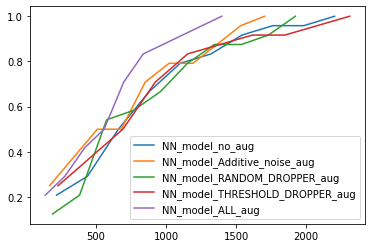

In [ ]:
 # get the probability distribution for each row in the test_rss.
 # get the estimated location ID as a location that has the highet probability for each row in test_rss
 # calculate the error



########### WITHOUT   AUGMENTATION
one_hot_encoder_24=one_hot_encoded_vec()
location_model_1=train_model(fingerprint_rss,one_hot_encoder_24)
Test_model(test_rss,one_hot_encoder_24)
locations_classes_1=location_model_1.predict_classes(test_rss)
model_eculidan_distance=[]
for i in range(24):
  model_eculidan_distance.append(euclidean_distance(test_locs[i][0],test_locs[i][1],test_locs[locations_classes_1[i]][0],test_locs[locations_classes_1[i]][1]))
print(np.median(model_eculidan_distance))
print(np.mean(model_eculidan_distance))
CDF_draw(model_eculidan_distance,"NN_model_no_aug")
plt.legend()
##########




########### WITH  ADDITIVE_NOISE AUGMENTATION
fingerprint_rss_Additive_noise,fingerprint_locs_Additive_noise,one_hot_encoder_new_1 =Additive_noise()
location_model_2=train_model(fingerprint_rss_Additive_noise , one_hot_encoder_new_1)
Test_model(test_rss,one_hot_encoder_24)
locations_classes_2=location_model_2.predict_classes(test_rss)
model_eculidan_distance=[]
for i in range(24):
  model_eculidan_distance.append(euclidean_distance(test_locs[i][0],test_locs[i][1],test_locs[locations_classes_2[i]][0],test_locs[locations_classes_2[i]][1]))
print(np.median(model_eculidan_distance))
print(np.mean(model_eculidan_distance))
CDF_draw(model_eculidan_distance,"NN_model_Additive_noise_aug")
plt.legend()
##########


########### WITH  Random_Dropper_AP AUG
fingerprint_rss_Random_Dropper_AP,fingerprint_locs_Random_Dropper_AP,one_hot_encoder_new_2 =Random_Dropper_AP()
location_model_3=train_model(fingerprint_rss_Random_Dropper_AP , one_hot_encoder_new_2)
Test_model(test_rss,one_hot_encoder_24)
locations_classes_3=location_model_3.predict_classes(test_rss)
model_eculidan_distance=[]
for i in range(24):
  model_eculidan_distance.append(euclidean_distance(test_locs[i][0],test_locs[i][1],test_locs[locations_classes_3[i]][0],test_locs[locations_classes_3[i]][1]))
print(np.median(model_eculidan_distance))
print(np.mean(model_eculidan_distance))
CDF_draw(model_eculidan_distance,"NN_model_RANDOM_DROPPER_aug")
plt.legend()
##########




########### WITH  Threshold_dropper AUG
fingerprint_rss_Threshold_dropper,fingerprint_locs_threshold_dropper,one_hot_encoder_new_3 =Threshold_dropper()
location_model_4=train_model(fingerprint_rss_Threshold_dropper , one_hot_encoder_new_3)
Test_model(test_rss,one_hot_encoder_24)
locations_classes_4=location_model_4.predict_classes(test_rss)
model_eculidan_distance=[]
for i in range(24):
  model_eculidan_distance.append(euclidean_distance(test_locs[i][0],test_locs[i][1],test_locs[locations_classes_4[i]][0],test_locs[locations_classes_4[i]][1]))
print(np.median(model_eculidan_distance))
print(np.mean(model_eculidan_distance))
CDF_draw(model_eculidan_distance,"NN_model_THRESHOLD_DROPPER_aug")
plt.legend()
##########



##########  WITH ALL AUGMENTATION TECHNIQUES

fingerprint_rss_all=[]
encoded_vector_all=[]
fingerprint_rss_all.extend(fingerprint_rss_Additive_noise)
fingerprint_rss_all.extend(fingerprint_rss_Random_Dropper_AP)
fingerprint_rss_all.extend(fingerprint_rss_Threshold_dropper)
encoded_vector_all.extend(one_hot_encoder_new_1)
encoded_vector_all.extend(one_hot_encoder_new_2)
encoded_vector_all.extend(one_hot_encoder_new_3)

location_model_5=train_model(fingerprint_rss_all , encoded_vector_all)
Test_model(test_rss,one_hot_encoder_24)
locations_classes_5=location_model_5.predict_classes(test_rss)
model_eculidan_distance=[]
for i in range(24):
  model_eculidan_distance.append(euclidean_distance(test_locs[i][0],test_locs[i][1],test_locs[locations_classes_5[i]][0],test_locs[locations_classes_5[i]][1]))
print(np.median(model_eculidan_distance))
print(np.mean(model_eculidan_distance))
CDF_draw(model_eculidan_distance,"NN_model_ALL_aug")
plt.legend()

#########



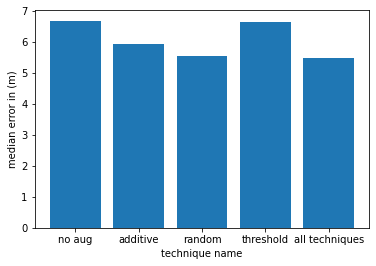

In [ ]:
import matplotlib.pyplot as plt
technique = ['no aug', 'additive', 'random', 'threshold' , 'all techniques']
median_error_technique= [6.69, 5.95,5.55,6.66,5.48]
plt.bar(technique,median_error_technique)
plt.xlabel('technique name')
plt.ylabel('median error in (m)')
plt.show()

Model: "sequential_99"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_396 (Dense)            (None, 256)               1280      
_________________________________________________________________
dropout_99 (Dropout)         (None, 256)               0         
_________________________________________________________________
dense_397 (Dense)            (None, 128)               32896     
_________________________________________________________________
dense_398 (Dense)            (None, 64)                8256      
_________________________________________________________________
dense_399 (Dense)            (None, 24)                1560      
Total params: 43,992
Trainable params: 43,992
Non-trainable params: 0
_________________________________________________________________
Epoch 1/10
24/24 [==============================] - 0s 2ms/step - loss: 18.5717 - accuracy: 0.0265
Epoch 2/10
24/24

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


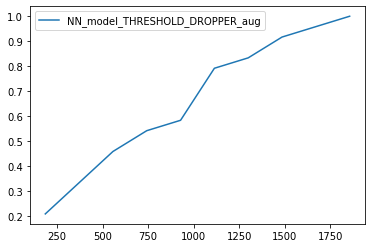

In [ ]:
fingerprint_rss_Threshold_dropper,fingerprint_locs_threshold_dropper,one_hot_encoder_new_3 =Threshold_dropper(-95)
location_model_4=train_model(fingerprint_rss_Threshold_dropper , one_hot_encoder_new_3)
Test_model(test_rss,one_hot_encoder_24)
locations_classes_4=location_model_4.predict_classes(test_rss)
model_eculidan_distance=[]
for i in range(24):
  model_eculidan_distance.append(euclidean_distance(test_locs[i][0],test_locs[i][1],test_locs[locations_classes_4[i]][0],test_locs[locations_classes_4[i]][1]))
print(np.median(model_eculidan_distance))
print(np.mean(model_eculidan_distance))
CDF_draw(model_eculidan_distance,"NN_model_THRESHOLD_DROPPER_aug")
plt.legend()

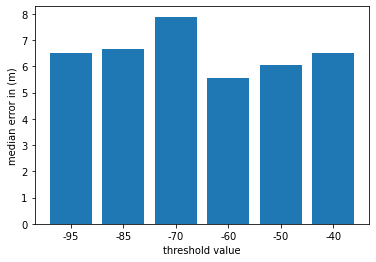

In [ ]:
differen_threshold = ['-95','-85', '-70', '-60', '-50' , '-40']
median_error_technique= [6.52,6.66, 7.89,5.55,6.05,6.52]
plt.bar(differen_threshold,median_error_technique)
plt.xlabel('threshold value')
plt.ylabel('median error in (m)')
plt.show()

# 3. Requirements
It is required to implement the following,
*   The different data augmentation techniques.
*   The Deep learning-based localization system using a classifier with the described parameters.
*   Draw the Cumulative distribution function (CDF) for the distance error using the proposed test data .
*   Compare the CDF for the deep learning-based system with all augmentation techniques and without augmentation.
*   Draw a figure that shows the effect of no augmentation, each data augmentation technique, and all data augmentation techniques on the median localization error.
*   Draw a figure that shows the effect of changing the threshold parameter on the median localization error using theshold-based dropping.


# 5. Possible resources
*   [Data Augmentation Paper](https://arxiv.org/pdf/1906.08171)

# 6. Final notes

*   It is reuired to deliver the notebook with the Deep learning & Data Augmentation implementation, the CDFs and the error statistics (mean and median.
*   Assignment delivery date is on Tuesday **May 11**.







